### Install the beacon_api package to interact with the Beacon Data Lake API

You can find the package on PyPI: https://pypi.org/project/beacon-api/

If you run into any issues, please refer to the GitHub repository: https://github.com/maris-development/beacon

Documentation fo the beacon_api package can be found here: https://maris-development.github.io/beacon/docs/1.2.0/query-docs/getting-started.html#python


In [ ]:
%pip install beacon_api --upgrade
from beacon_api import * # Import the Beacon API client
import os

#### In order to get access to the Beacon endpoint, you will need a token.

The notebook will fetch the Token for you when running in the D4science VRE.
If you are running the notebook outside the D4Science VRE you will need to get the token from the D4science DDAS (https://data.blue-cloud.org/search) and fill it in manually.


In [ ]:
TOKEN = os.getenv('D4SCIENCE_TOKEN') # This will fetch the token from the VRE environment.
# If you want to run this notebook locally, you can set the TOKEN variable directly here:
#TOKEN = "<your_token>" # Get your token from https://blue-cloud.d4science.org/group/blue-cloudlab/authorization. Simply press "Get Token" and copy the token here.
BEACON_INSTANCE_URL = "https://beacon-emod-chem.maris.nl" # Can optionally be replaced with the Beacon running on D4Science: https://beacon-emodnet-chemistry.d4science.org

#### Connect to the Beacon Data Lake


In [3]:
client = Client(BEACON_INSTANCE_URL, jwt_token=TOKEN)

Connected to: https://beacon-emod-chem.maris.nl/ server successfully


#### List the available columns and their data types (e.g., string, integer) that can be queried.


In [4]:
client.available_columns_with_data_type()

Cruise: string
Station: string
Type: string
yyyy-mm-ddThh:mm:ss.sss: timestamp[ms]
Longitude: float
Latitude: float
LOCAL_CDI_ID: string
EDMO_code: int64
Bot. Depth: float
Instrument Info: string
Codes in Originator File: string
P35 Contributor Codes: string
References: string
Comments: string
Data set name: string
Discipline: string
Category: string
Variables measured: string
Data format: string
Data format version: string
Data size: string
Data set creation date: string
Datum: string
Measuring area type: string
Water depth: float
Depth reference: string
Minimum instrument depth: float
Maximum instrument depth: float
Start date: string
Start time: string
End date: string
End time: string
Vertical resolution: string
Vertical resolution unit: string
Instrument / gear type: string
Track resolution: string
Track resolution unit: string
Frequency: string
Frequency unit: string
Platform type: string
Cruise name: string
Alternative cruise name: string
Cruise start date: string
Station name: 

I'll look for the parameters in previously mentioned:

> **Dissolved nitrogen** and **phosphorous** are the main inorganic **nutrients** in the water column responsible for the eutrophication of marine waters. In their marine strategies, EU Member States need to look at the levels of **nutrient concentrations**, the levels of **chlorophyll concentrations**, the spatial extent and duration of harmful algal blooms, the **transparency of the water column**, and the levels of **dissolved oxygen** in the water


In [5]:
# search for a specific column
columns = client.available_columns_with_data_type()
search_term = "originator"
[field for field in columns if search_term in field.name.lower()]

[pyarrow.Field<Codes in Originator File: string>,
 pyarrow.Field<Originator: string>,
 pyarrow.Field<Codes in Originator File.qf_schema: string>,
 pyarrow.Field<Originator.qf_schema: string>]

#### Build a query


In [6]:

df = (
    client.query()
    .add_select_column(
        "yyyy-mm-ddThh:mm:ss.sss", alias="time"
    )  # Select the columns you want to retrieve
    .add_select_column("Latitude", alias="latitude")
    .add_select_column("Longitude", alias="longitude")
    .add_select_column("Depth", alias="depth")
    .add_select_column("Water body dissolved inorganic nitrogen (DIN)", alias="Water body dissolved inorganic nitrogen (DIN)")
    .add_select_column("Water body dissolved inorganic nitrogen (DIN)_qc", alias="Water body dissolved inorganic nitrogen (DIN)_qc")
    .add_select_column("Water body nitrate", alias="Water body nitrate")
    .add_select_column("Water body nitrate_qc", alias="Water body nitrate_qc")
    .add_select_column("Water body chlorophyll-a", alias="Water body chlorophyll-a")
    .add_select_column("Water body chlorophyll-a_qc", alias="Water body chlorophyll-a_qc")
    .add_select_column("Water body dissolved oxygen concentration", alias="Water body dissolved oxygen concentration")
    .add_select_column("Water body dissolved oxygen concentration_qc", alias="Water body dissolved oxygen concentration_qc")
    .add_select_column("Water body phosphate", alias="Water body phosphate")
    .add_select_column("Water body phosphate_qc", alias="Water body phosphate_qc")
    .add_range_filter(
        "time", "2020-01-01T00:00:00", "2023-12-31T23:59:59"
    )  # You can adjust the date range as needed. The format is ISO 8601.
    .add_range_filter(
        "latitude", -90, 90
    )  # Latitude range from -90 to 90 (you can adjust as needed)
    .add_range_filter(
        "longitude", -180, 180
    )  # Longitude range from -180 to 180 (you can adjust as needed)
    .add_range_filter(
        "depth", 0, 100
    )  # Depth range from 0 to 100 meters (you can adjust as needed)
    # .add_polygon_filter(
    #     "latitude",
    #     "longitude",
    #     [
    #         (13.77, 46.23),
    #         (11.14, 44.72),
    #         (12.15, 43.46),
    #         (15.05, 40.79),
    #         (16.37, 39.17),
    #         (21.29, 39.04),
    #         (21.33, 41.88),
    #         (14.70, 46.63),
    #         (13.77, 46.23),
    #     ],
    # )  # Define a polygon area (you can adjust the coordinates as needed)
    .add_filter(
        OrFilter([IsNotNullFilter("Water body chlorophyll-a"), IsNotNullFilter("Water body dissolved oxygen concentration"), IsNotNullFilter("Water body phosphate"), IsNotNullFilter("Water body nitrate")])
    )  # Ensure the parameter selected is not null
    .to_pandas_dataframe()  # Convert the results to a pandas DataFrame. This will execute the query. You can use any of the other 'to_*' methods to get the results in different formats.
    #  .to_netcdf("./file_path")  # You can also use .to_parquet() to get the results in Parquet format
    #  .to_parquet("./file_path")  # You can also use .to_netcdf() to get the results in NetCDF format
    #  .to_zarr("./file_path")  # You can also use .to_zarr() to get the results in Zarr format
    # .to_geo_pandas_dataframe("longitude","latitude")
)
df

Running query: {"from": "default", "select": [{"column": "yyyy-mm-ddThh:mm:ss.sss", "alias": "time"}, {"column": "Latitude", "alias": "latitude"}, {"column": "Longitude", "alias": "longitude"}, {"column": "Depth", "alias": "depth"}, {"column": "Water body dissolved inorganic nitrogen (DIN)", "alias": "Water body dissolved inorganic nitrogen (DIN)"}, {"column": "Water body dissolved inorganic nitrogen (DIN)_qc", "alias": "Water body dissolved inorganic nitrogen (DIN)_qc"}, {"column": "Water body nitrate", "alias": "Water body nitrate"}, {"column": "Water body nitrate_qc", "alias": "Water body nitrate_qc"}, {"column": "Water body chlorophyll-a", "alias": "Water body chlorophyll-a"}, {"column": "Water body chlorophyll-a_qc", "alias": "Water body chlorophyll-a_qc"}, {"column": "Water body dissolved oxygen concentration", "alias": "Water body dissolved oxygen concentration"}, {"column": "Water body dissolved oxygen concentration_qc", "alias": "Water body dissolved oxygen concentration_qc"},

,time,latitude,longitude,depth,Water body dissolved inorganic nitrogen (DIN),Water body dissolved inorganic nitrogen (DIN)_qc,Water body nitrate,Water body nitrate_qc,Water body chlorophyll-a,Water body chlorophyll-a_qc,Water body dissolved oxygen concentration,Water body dissolved oxygen concentration_qc,Water body phosphate,Water body phosphate_qc
0,2022-08-12 11:36:00,59.982449,-22.768646,1.584913,NaN,9,NaN,9,NaN,9,262.215759,1,NaN,9
1,2022-08-12 11:36:00,59.982449,-22.768646,2.377365,NaN,9,NaN,9,NaN,9,262.179260,1,NaN,9
2,2022-08-12 11:36:00,59.982449,-22.768646,3.268869,NaN,9,NaN,9,NaN,9,262.144257,1,NaN,9
3,2022-08-12 11:36:00,59.982449,-22.768646,4.457536,NaN,9,NaN,9,NaN,9,262.114471,1,NaN,9
4,2022-08-12 11:36:00,59.982449,-22.768646,5.646196,NaN,9,NaN,9,NaN,9,261.994202,1,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920102,2023-11-17 11:12:00,72.573349,28.608879,94.913063,NaN,9,NaN,9,0.0657,2,292.964478,1,NaN,9
1920103,2023-11-17 11:12:00,72.573349,28.608879,95.902336,NaN,9,NaN,9,0.0567,2,293.029053,1,NaN,9
1920104,2023-11-17 11:12:00,72.573349,28.608879,96.990524,NaN,9,NaN,9,0.0609,2,292.973694,1,NaN,9
1920105,2023-11-17 11:12:00,72.573349,28.608879,97.979782,NaN,9,NaN,9,0.0591,2,293.040344,1,NaN,9


In [7]:
#statisctics per parameter
df.describe()

,time,latitude,longitude,depth,Water body dissolved inorganic nitrogen (DIN),Water body nitrate,Water body chlorophyll-a,Water body dissolved oxygen concentration,Water body phosphate
count,1920107,1.920107e+06,1.920107e+06,1.920107e+06,8503.000000,75738.000000,915369.000000,1.531730e+06,74770.000000
mean,2022-02-21 10:55:08.116000,5.691449e+01,-3.395259e+00,3.953315e+01,7.182882,6.269328,0.518725,3.075546e+02,0.604217
min,2020-01-01 00:37:00,2.442410e+01,-4.370081e+01,0.000000e+00,0.032000,-1.382725,-18.614901,-2.238828e+03,-0.010000
25%,2021-04-12 06:09:30,4.892883e+01,-1.709592e+01,1.077847e+01,0.488842,1.420000,0.062000,2.461291e+02,0.166833
50%,2022-04-19 07:17:29,5.571019e+01,-1.093842e+00,3.413895e+01,2.827000,5.533319,0.192000,2.858291e+02,0.460000
75%,2023-01-21 10:03:26,6.861767e+01,1.026773e+01,6.500000e+01,7.130000,10.398625,0.522000,3.155370e+02,0.690000
max,2023-12-31 16:23:00,8.994434e+01,7.704036e+01,1.000000e+02,1000.320000,467.470001,250.000000,6.548561e+03,26.129999
std,NaN,1.238940e+01,2.045898e+01,3.025404e+01,27.548779,6.874302,1.720039,2.928366e+02,1.081680


In [8]:
# plot the amount of data available per parameter and per year 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df['year'] = pd.DatetimeIndex(df['time']).year
df_melted = df.melt(
    id_vars=['year'],
    value_vars=[
        'Water body dissolved inorganic nitrogen (DIN)',
        'Water body nitrate',
        'Water body chlorophyll-a',
        'Water body dissolved oxygen concentration',
        'Water body phosphate'
    ],
    var_name='parameter',
    value_name='value'
)
df_melted = df_melted.dropna(subset=['value'])
plt.figure(figsize=(12, 6))
sns.countplot(data=df_melted, x='year', hue='parameter')
plt.title('Number of Observations per Parameter per Year')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.legend(title='Parameter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'

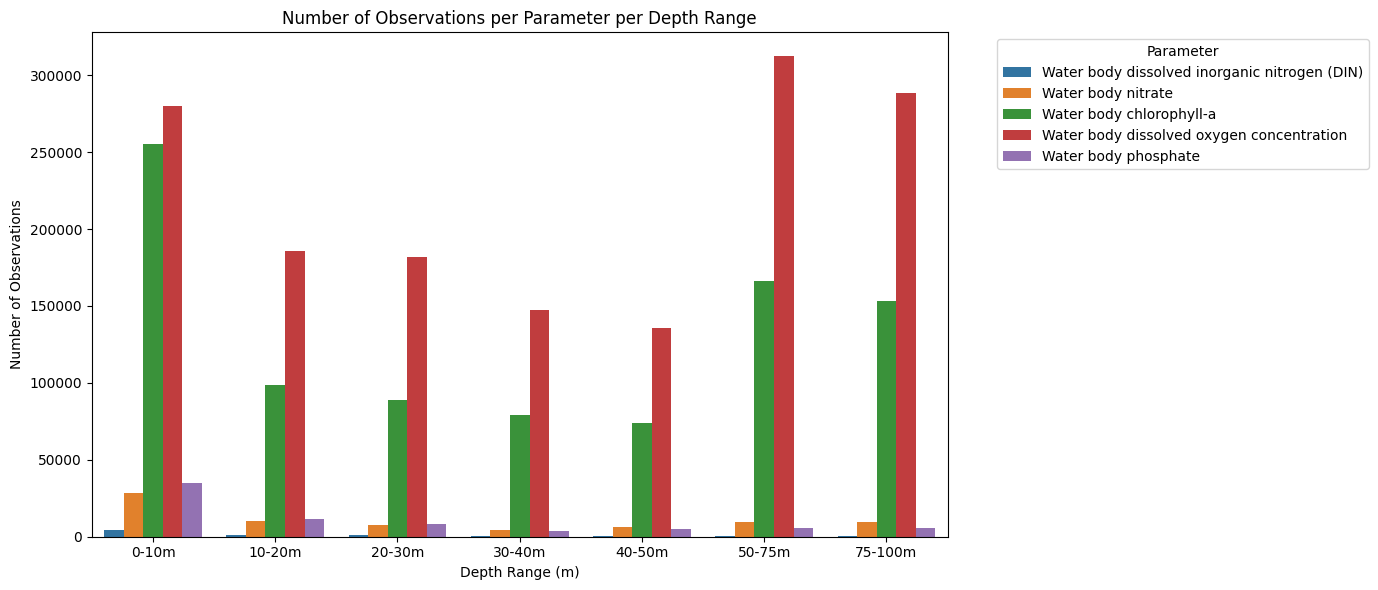

In [ ]:
# Plot the amount of data available per parameter and per depth range

import matplotlib.pyplot as plt
import seaborn as sns

# Bin depth into ranges (e.g., every 10 meters)
depth_bins = [0, 10, 20, 30, 40, 50, 75, 100]
depth_labels = [f"{depth_bins[i]}-{depth_bins[i+1]}m" for i in range(len(depth_bins)-1)]
df['depth_range'] = pd.cut(df['depth'], bins=depth_bins, labels=depth_labels, include_lowest=True)

df_melted = df.melt(
    id_vars=['depth_range'],
    value_vars=[
        'Water body dissolved inorganic nitrogen (DIN)',
        'Water body nitrate',
        'Water body chlorophyll-a',
        'Water body dissolved oxygen concentration',
        'Water body phosphate'
    ],
    var_name='parameter',
    value_name='value'
)
df_melted = df_melted.dropna(subset=['value'])

plt.figure(figsize=(14, 6))
sns.countplot(data=df_melted, x='depth_range', hue='parameter')
plt.title('Number of Observations per Parameter per Depth Range')
plt.xlabel('Depth Range (m)')
plt.ylabel('Number of Observations')
plt.legend(title='Parameter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# availability percentage per parameter
total_count = len(df)
availability_percentage = (df.notnull().sum() / total_count) * 100
print(availability_percentage)



time                                                100.000000
latitude                                            100.000000
longitude                                           100.000000
depth                                               100.000000
Water body dissolved inorganic nitrogen (DIN)         0.442840
Water body dissolved inorganic nitrogen (DIN)_qc     88.280653
Water body nitrate                                    3.944468
Water body nitrate_qc                                99.995157
Water body chlorophyll-a                             47.672812
Water body chlorophyll-a_qc                          99.963752
Water body dissolved oxygen concentration            79.773158
Water body dissolved oxygen concentration_qc         99.963752
Water body phosphate                                  3.894054
Water body phosphate_qc                             100.000000
year                                                100.000000
depth_range                                         100

#### Using the Query Builder to dynamically create queries


In [9]:
query = client.query() # Create a new query builder instance
query.add_select(Functions.concat(["EDMO_code", "LOCAL_CDI_ID"], alias="odv_tag")) # You can also use functions to create derived columns. Here we concatenate the EDMO_code and LOCAL_CDI_ID columns into a new column called odv_tag which should uniquely identify a dataset. This is required for ODV output.
query.add_select_column("yyyy-mm-ddThh:mm:ss.sss", alias="time")
query.add_select_column("Latitude", alias="latitude")
query.add_select_column("Longitude", alias="longitude")
query.add_select_column("Depth", alias="depth")
query.add_select_column("Water body dissolved inorganic nitrogen (DIN)", alias="Water body dissolved inorganic nitrogen (DIN)")
query.add_select_column("Water body dissolved inorganic nitrogen (DIN)_qc", alias="Water body dissolved inorganic nitrogen (DIN)_qc")
query.add_select_column("Water body nitrate", alias="Water body nitrate")
query.add_select_column("Water body nitrate_qc", alias="Water body nitrate_qc")
query.add_select_column("Water body chlorophyll-a", alias="Water body chlorophyll-a")
query.add_select_column("Water body chlorophyll-a_qc", alias="Water body chlorophyll-a_qc")
query.add_select_column("Water body dissolved oxygen concentration", alias="Water body dissolved oxygen concentration")
query.add_select_column("Water body dissolved oxygen concentration_qc", alias="Water body dissolved oxygen concentration_qc")
query.add_select_column("Water body phosphate", alias="Water body phosphate")
query.add_select_column("Water body phosphate_qc", alias="Water body phosphate_qc")
# add metadata columns if needed
query.add_select_column("Originator", alias="Originator")
query.add_select_column("CDI-record id", alias="CDI-record id")
query.add_select_column("EDMO_code", alias="EDMO_code")
query.add_select_column("Platform type", alias="Platform type")

query.add_filter(
        OrFilter([IsNotNullFilter("Water body dissolved inorganic nitrogen (DIN)"), IsNotNullFilter("Water body nitrate"), IsNotNullFilter("Water body chlorophyll-a"), IsNotNullFilter("Water body dissolved oxygen concentration"), IsNotNullFilter("Water body phosphate")])
    )
query.add_range_filter("time", "2020-01-01T00:00:00", "2023-12-31T23:59:59") # You can adjust the date range as needed. The format is ISO 8601.

Here is an example on how to dynamically set the output


In [10]:
import ipywidgets as widgets
from IPython.display import display

output_widget = widgets.Dropdown(
    options=["odv", "netcdf", "parquet", "zarr"],
    value="odv",
    description="Output type:",
)
display(output_widget)

output = output_widget.value

ModuleNotFoundError: No module named 'ipywidgets'

In [11]:
output = "odv"
if output == "odv":
    odv_output = Odv(
        longitude_column=OdvDataColumn("longitude"),
        latitude_column=OdvDataColumn("latitude"),
        depth_column=OdvDataColumn("depth"),
        time_column=OdvDataColumn("time"),
        data_columns=[OdvDataColumn("Water body dissolved oxygen concentration", qf_column="Water body dissolved oxygen concentration_qc"), 
                      OdvDataColumn("Water body nitrate", qf_column="Water body nitrate_qc"),
                      OdvDataColumn("Water body dissolved inorganic nitrogen (DIN)", qf_column="Water body dissolved inorganic nitrogen (DIN)_qc"),
                      OdvDataColumn("Water body chlorophyll-a", qf_column="Water body chlorophyll-a_qc"), OdvDataColumn("Water body dissolved oxygen concentration", qf_column="Water body dissolved oxygen concentration_qc"), 
                      OdvDataColumn("Water body phosphate", qf_column="Water body phosphate_qc"),],
        metadata_columns=[OdvDataColumn("Originator"), OdvDataColumn("CDI-record id"), OdvDataColumn("EDMO_code"), OdvDataColumn("Platform type")],
        key_column="odv_tag", # This column should uniquely identify a dataset
        qf_schema="SEADATANET",
    )
    query.to_odv(odv_output, "output.zip")
elif output == "netcdf":
    query.to_netcdf("output.nc")
elif output == "parquet":
    query.to_parquet("output.parquet")
elif output == "zarr":
    query.to_zarr("output.zarr")
else:
    df = query.to_pandas_dataframe()
    df

Running query: {"from": "default", "select": [{"function": "concat", "args": [{"column": "EDMO_code", "alias": null}, {"column": "LOCAL_CDI_ID", "alias": null}], "alias": "odv_tag"}, {"column": "yyyy-mm-ddThh:mm:ss.sss", "alias": "time"}, {"column": "Latitude", "alias": "latitude"}, {"column": "Longitude", "alias": "longitude"}, {"column": "Depth", "alias": "depth"}, {"column": "Water body dissolved inorganic nitrogen (DIN)", "alias": "Water body dissolved inorganic nitrogen (DIN)"}, {"column": "Water body dissolved inorganic nitrogen (DIN)_qc", "alias": "Water body dissolved inorganic nitrogen (DIN)_qc"}, {"column": "Water body nitrate", "alias": "Water body nitrate"}, {"column": "Water body nitrate_qc", "alias": "Water body nitrate_qc"}, {"column": "Water body chlorophyll-a", "alias": "Water body chlorophyll-a"}, {"column": "Water body chlorophyll-a_qc", "alias": "Water body chlorophyll-a_qc"}, {"column": "Water body dissolved oxygen concentration", "alias": "Water body dissolved oxy

In [12]:
df

,time,latitude,longitude,depth,Water body dissolved inorganic nitrogen (DIN),Water body dissolved inorganic nitrogen (DIN)_qc,Water body nitrate,Water body nitrate_qc,Water body chlorophyll-a,Water body chlorophyll-a_qc,Water body dissolved oxygen concentration,Water body dissolved oxygen concentration_qc,Water body phosphate,Water body phosphate_qc
0,2022-08-12 11:36:00,59.982449,-22.768646,1.584913,NaN,9,NaN,9,NaN,9,262.215759,1,NaN,9
1,2022-08-12 11:36:00,59.982449,-22.768646,2.377365,NaN,9,NaN,9,NaN,9,262.179260,1,NaN,9
2,2022-08-12 11:36:00,59.982449,-22.768646,3.268869,NaN,9,NaN,9,NaN,9,262.144257,1,NaN,9
3,2022-08-12 11:36:00,59.982449,-22.768646,4.457536,NaN,9,NaN,9,NaN,9,262.114471,1,NaN,9
4,2022-08-12 11:36:00,59.982449,-22.768646,5.646196,NaN,9,NaN,9,NaN,9,261.994202,1,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920102,2023-11-17 11:12:00,72.573349,28.608879,94.913063,NaN,9,NaN,9,0.0657,2,292.964478,1,NaN,9
1920103,2023-11-17 11:12:00,72.573349,28.608879,95.902336,NaN,9,NaN,9,0.0567,2,293.029053,1,NaN,9
1920104,2023-11-17 11:12:00,72.573349,28.608879,96.990524,NaN,9,NaN,9,0.0609,2,292.973694,1,NaN,9
1920105,2023-11-17 11:12:00,72.573349,28.608879,97.979782,NaN,9,NaN,9,0.0591,2,293.040344,1,NaN,9
